# BayesNet

A `BayesNet` in GTSAM represents a directed graphical model, created by running sequential variable elimination (like Cholesky or QR factorization) on a `FactorGraph` or constructing from scratch.

It is essentially a collection of `Conditional` objects, ordered according to the elimination order. Each conditional represents $P(\text{variable} | \text{parents})$, where the parents are variables that appear later in the elimination ordering.

A Bayes net represents the joint probability distribution as a product of conditional probabilities stored in the net:

$$
P(X_1, X_2, \dots, X_N) = \prod_{i=1}^N P(X_i | \text{Parents}(X_i))
$$
The total log-probability of an assignment is the sum of the log-probabilities of its conditionals:
$$
\log P(X_1, \dots, X_N) = \sum_{i=1}^N \log P(X_i | \text{Parents}(X_i))
$$

Like `FactorGraph`, `BayesNet` is templated on the type of conditional it stores (e.g., `GaussianBayesNet`, `DiscreteBayesNet`).

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/gtsam/inference/doc/BayesNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install --quiet gtsam-develop

In [44]:
import gtsam
import numpy as np
import graphviz

# We need concrete graph types and elimination to get a BayesNet
from gtsam import GaussianFactorGraph, Ordering, GaussianBayesNet
# For the Asia example
from gtsam import DiscreteBayesNet, DiscreteConditional, DiscreteKeys, DiscreteValues, symbol
from gtsam import symbol_shorthand

X = symbol_shorthand.X
L = symbol_shorthand.L

## Creating a BayesNet (via Elimination)

BayesNets are typically obtained by eliminating a `FactorGraph`.

In [45]:
# Create a simple Gaussian Factor Graph P(x0) P(x1|x0) P(x2|x1)
graph = GaussianFactorGraph()
model = gtsam.noiseModel.Isotropic.Sigma(1, 1.0)
graph.add(X(0), -np.eye(1), np.zeros(1), model)
graph.add(X(0), -np.eye(1), X(1), np.eye(1), np.zeros(1), model)
graph.add(X(1), -np.eye(1), X(2), np.eye(1), np.zeros(1), model)
print("Original Factor Graph:")
graph.print()

Original Factor Graph:

size: 3
factor 0: 
  A[x0] = [
	-1
]
  b = [ 0 ]
  Noise model: unit (1) 
factor 1: 
  A[x0] = [
	-1
]
  A[x1] = [
	1
]
  b = [ 0 ]
  Noise model: unit (1) 
factor 2: 
  A[x1] = [
	-1
]
  A[x2] = [
	1
]
  b = [ 0 ]
  Noise model: unit (1) 


In [46]:
# Eliminate sequentially using a specific ordering
ordering = Ordering([X(0), X(1), X(2)])
bayes_net = graph.eliminateSequential(ordering)

print("\nResulting BayesNet:")
bayes_net.print()


Resulting BayesNet:

size: 3
conditional 0:  p(x0 | x1)
  R = [ 1.41421 ]
  S[x1] = [ -0.707107 ]
  d = [ 0 ]
  logNormalizationConstant: -0.572365
  No noise model
conditional 1:  p(x1 | x2)
  R = [ 1.22474 ]
  S[x2] = [ -0.816497 ]
  d = [ 0 ]
  logNormalizationConstant: -0.716206
  No noise model
conditional 2:  p(x2)
  R = [ 0.57735 ]
  d = [ 0 ]
  mean: 1 elements
  x2: 0
  logNormalizationConstant: -1.46824
  No noise model


## Properties and Access

A `BayesNet` provides access to its constituent conditionals and basic properties.

In [47]:
print(f"BayesNet size: {bayes_net.size()}")

# Access conditional by index
conditional1 = bayes_net.at(1)
print("Conditional at index 1: ")
conditional1.print()

# Get all keys involved
bn_keys = bayes_net.keys()
print(f"Keys in BayesNet: {bn_keys}")

BayesNet size: 3
Conditional at index 1: 
GaussianConditional p(x1 | x2)
  R = [ 1.22474 ]
  S[x2] = [ -0.816497 ]
  d = [ 0 ]
  logNormalizationConstant: -0.716206
  No noise model
Keys in BayesNet: x0x1x2


## Evaluation and Solution

The `logProbability(Values)` method computes the log probability of a variable assignment given the conditional distributions in the Bayes net. For Gaussian Bayes nets, the `optimize()` method can be used to find the maximum likelihood estimate (MLE) solution via back-substitution.

In [48]:
# For GaussianBayesNet, we use VectorValues
mle_solution = bayes_net.optimize()

# Calculate log probability (requires providing values for all variables)
log_prob = bayes_net.logProbability(mle_solution)
print(f"Log Probability at {mle_solution.at(X(0))[0]:.0f},{mle_solution.at(X(1))[0]:.0f},{mle_solution.at(X(2))[0]:.0f}]: {log_prob}")

print("Optimized Solution (MLE):")
mle_solution.print()

Log Probability at 0,0,0]: -2.7568155996140185
Optimized Solution (MLE):
VectorValues: 3 elements
  x0: 0
  x1: 0
  x2: 0


## Visualization

Bayes nets can also be visualized using Graphviz.

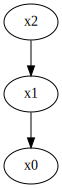

In [49]:
graphviz.Source(bayes_net.dot())

## Example: DiscreteBayesNet (Asia Network)

While the previous examples focused on `GaussianBayesNet`, GTSAM also supports `DiscreteBayesNet` for representing probability distributions over discrete variables. Here we construct the classic 'Asia' network example directly by adding `DiscreteConditional` objects.

In [50]:
# Define keys for the Asia network variables
A = symbol('A', 8) # Visit to Asia?
S = symbol('S', 7) # Smoker?
T = symbol('T', 6) # Tuberculosis?
L = symbol('L', 5) # Lung Cancer?
B = symbol('B', 4) # Bronchitis?
E = symbol('E', 3) # Tuberculosis or Lung Cancer?
X = symbol('X', 2) # Positive X-Ray?
D = symbol('D', 1) # Dyspnea (Shortness of breath)?

# Define cardinalities (all are binary in this case)
cardinalities = { A: 2, S: 2, T: 2, L: 2, B: 2, E: 2, X: 2, D: 2 }

# Helper to create DiscreteKeys object
def make_keys(keys_list):
    dk = DiscreteKeys()
    for k in keys_list:
        dk.push_back((k, cardinalities[k]))
    return dk

In [51]:
# Create the DiscreteBayesNet
asia_net = DiscreteBayesNet()

# Helper function to create parent list in correct format
def make_parent_tuples(parent_keys):
    return [(pk, cardinalities[pk]) for pk in parent_keys]

# P(D | E, B) - Dyspnea given Either and Bronchitis
asia_net.add(DiscreteConditional((D, cardinalities[D]), make_parent_tuples([E, B]), "9/1 2/8 3/7 1/9"))

# P(X | E) - X-Ray result given Either
asia_net.add(DiscreteConditional((X, cardinalities[X]), make_parent_tuples([E]), "95/5 2/98"))

# P(E | T, L) - Either Tub. or Lung Cancer (OR gate)
# "F T T T" means P(E=1|T=0,L=0)=0, P(E=1|T=0,L=1)=1, P(E=1|T=1,L=0)=1, P(E=1|T=1,L=1)=1
asia_net.add(DiscreteConditional((E, cardinalities[E]), make_parent_tuples([T, L]), "F T T T"))

# P(B | S) - Bronchitis given Smoker
asia_net.add(DiscreteConditional((B, cardinalities[B]), make_parent_tuples([S]), "70/30 40/60"))

# P(L | S) - Lung Cancer given Smoker
asia_net.add(DiscreteConditional((L, cardinalities[L]), make_parent_tuples([S]), "99/1 90/10"))

# P(T | A) - Tuberculosis given Asia
asia_net.add(DiscreteConditional((T, cardinalities[T]), make_parent_tuples([A]), "99/1 95/5"))

# P(S) - Prior on Smoking
asia_net.add(DiscreteConditional((S, cardinalities[S]), [], "1/1")) # or "50/50"

# Add conditional probability tables (CPTs) using C++ sugar syntax
# P(A) - Prior on Asia
asia_net.add(DiscreteConditional((A, cardinalities[A]), [], "99/1"))

print("Asia Bayes Net:")
asia_net.print()

Asia Bayes Net:
DiscreteBayesNet
 
size: 8
conditional 0:  P( D1 | E3 B4 ):
 Choice(E3) 
 0 Choice(D1) 
 0 0 Choice(B4) 
 0 0 0 Leaf  0.9
 0 0 1 Leaf  0.2
 0 1 Choice(B4) 
 0 1 0 Leaf  0.1
 0 1 1 Leaf  0.8
 1 Choice(D1) 
 1 0 Choice(B4) 
 1 0 0 Leaf  0.3
 1 0 1 Leaf  0.1
 1 1 Choice(B4) 
 1 1 0 Leaf  0.7
 1 1 1 Leaf  0.9

conditional 1:  P( X2 | E3 ):
 Choice(X2) 
 0 Choice(E3) 
 0 0 Leaf 0.95
 0 1 Leaf 0.02
 1 Choice(E3) 
 1 0 Leaf 0.05
 1 1 Leaf 0.98

conditional 2:  P( E3 | T6 L5 ):
 Choice(T6) 
 0 Choice(L5) 
 0 0 Choice(E3) 
 0 0 0 Leaf    1
 0 0 1 Leaf    0
 0 1 Choice(E3) 
 0 1 0 Leaf    0
 0 1 1 Leaf    1
 1 Choice(L5) 
 1 0 Choice(E3) 
 1 0 0 Leaf    0
 1 0 1 Leaf    1
 1 1 Choice(E3) 
 1 1 0 Leaf    0
 1 1 1 Leaf    1

conditional 3:  P( B4 | S7 ):
 Choice(S7) 
 0 Choice(B4) 
 0 0 Leaf  0.7
 0 1 Leaf  0.3
 1 Choice(B4) 
 1 0 Leaf  0.4
 1 1 Leaf  0.6

conditional 4:  P( L5 | S7 ):
 Choice(S7) 
 0 Choice(L5) 
 0 0 Leaf 0.99
 0 1 Leaf 0.01
 1 Choice(L5) 
 1 0 Leaf  0.9
 1 1 Leaf

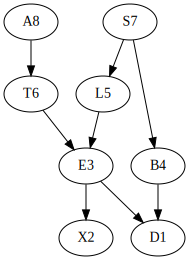

Log Probability of all zeros: -1.2366269421045588
Sampled Values (basic print):
DiscreteValues{4683743612465315848: 0, 4755801206503243780: 1, 4899916394579099649: 1, 4971973988617027587: 0, 5476377146882523141: 0, 5980780305148018695: 1, 6052837899185946630: 0, 6341068275337658370: 0}
Sampled Values (pretty print):
  A8: 0
  B4: 1
  D1: 1
  E3: 0
  L5: 0
  S7: 1
  T6: 0
  X2: 0


In [58]:
# Visualize the network structure
dot_string = asia_net.dot()
display(graphviz.Source(dot_string))

# Evaluate the log probability of a specific assignment
# Example: Calculate P(A=0, S=0, T=0, L=0, B=0, E=0, X=0, D=0)
values = DiscreteValues()
for key, card in cardinalities.items():
    values[key] = 0 # Assign 0 to all variables to start

log_prob_zeros = asia_net.logProbability(values)
print(f"Log Probability of all zeros: {log_prob_zeros}")

# Sample from the Bayes Net
sample = asia_net.sample()
print("Sampled Values (basic print):")
print(sample)

# --- Pretty Print ---
print("Sampled Values (pretty print):")
# Create a reverse mapping from integer key to string like 'A8'
# We defined A=symbol('A',8), S=symbol('S',7), etc. above
symbol_map = { A: 'A8', S: 'S7', T: 'T6', L: 'L5', B: 'B4', E: 'E3', X: 'X2', D: 'D1' }
# Iterate through the sampled values and print nicely
# Sort items by the symbol string for consistent order (optional)
for key, value in sorted(sample.items(), key=lambda item: symbol_map.get(item[0], str(item[0]))):
    symbol_str = symbol_map.get(key, f"UnknownKey({key})") # Get 'A8' from key A
    print(f"  {symbol_str}: {value}")